# 캐글따라하기(bike sharing demand)


출처 : [Tutorial with Bike Sharing Demand](https://www.kaggle.com/sidagar/tutorial-with-bike-sharing-demand)

이번 블로그는 캐글에서 돌아다니는 bike sharing demand의 대해 날씨, 휴일, 평일, 계절 등등에 따라 변하는 bike sharing demand의 대한 데이터를 가지고 재구성 및 시각화를 해보려 한다.

## 1. 데이터 불러오기

In [5]:
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

train 데이터를 먼저 불러온다.

In [7]:
train = pd.read_csv('/home/jaeyoon89/jaeyoon_study/train_bike.csv')

describe() 메서드로 전체 컬럼의 통계량을 알아보자.

In [34]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,Date,Hour,Day,Month,Year,s1,s2,s3,s4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,2011-01-01,0,1,1,2011,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,2011-01-01,1,1,1,2011,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,32,2011-01-01,2,1,1,2011,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,13,2011-01-01,3,1,1,2011,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,2011-01-01,4,1,1,2011,1,0,0,0


In [8]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


결측치가 있는지 확인해보니 train 데이터에는 결측치가 없는 것으로 나온다.

In [9]:
train.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [10]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

## 2. 연속적인 데이터의 시각화

먼저 train 데이터에 있는 모든 연속값의 heatmap을 그려보자.

In [12]:
corr = train[['temp','atemp','humidity', 'windspeed','casual', 'registered','count']].corr()

<AxesSubplot:>

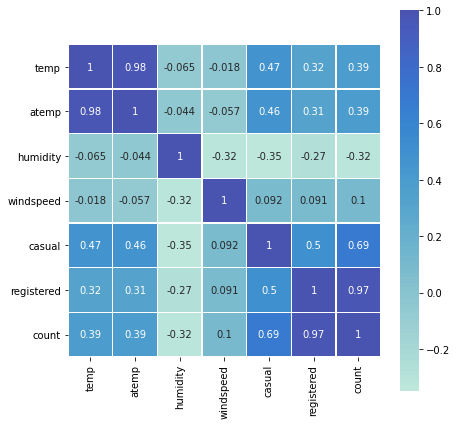

In [13]:
f,axes = plt.subplots(1,1,figsize = (7,7))
sb.heatmap(corr,square=True,annot = True,linewidth = .5,center = 2,ax = axes)

위 heatmap을 보면  온도와 체감온도가 매우 강한 양의 상관 관계를 가지고 있다는 것을 알 수 있다. 그렇기 때문에 온도와 체감온도만 변수로 사용할 수 있을 것 같다.

또한 위 heatmapt에서 windspeen(풍속)은 우리가 예측하고자 하는 casual(비회원), retistered(회원) 또는 대여수량이 상관관계가 없다는 것을 볼 수 있다. 예측하는데 있어제거해도 무방할 듯 하다.

## 3. 비연속적인 데이터의 시각화

먼저 각 데이터의 컬럼에 따라 날짜와 시간을 시간, 일, 월 및 년으로 구분해야 한다.

In [14]:
train = train
train['Date'] = pd.DatetimeIndex(train['datetime']).date
train['Hour'] = pd.DatetimeIndex(train['datetime']).hour
train['Day'] = pd.DatetimeIndex(train['datetime']).day
train['Month'] = pd.DatetimeIndex(train['datetime']).month
train['Year'] = pd.DatetimeIndex(train['datetime']).year

<AxesSubplot:xlabel='Date', ylabel='registered'>

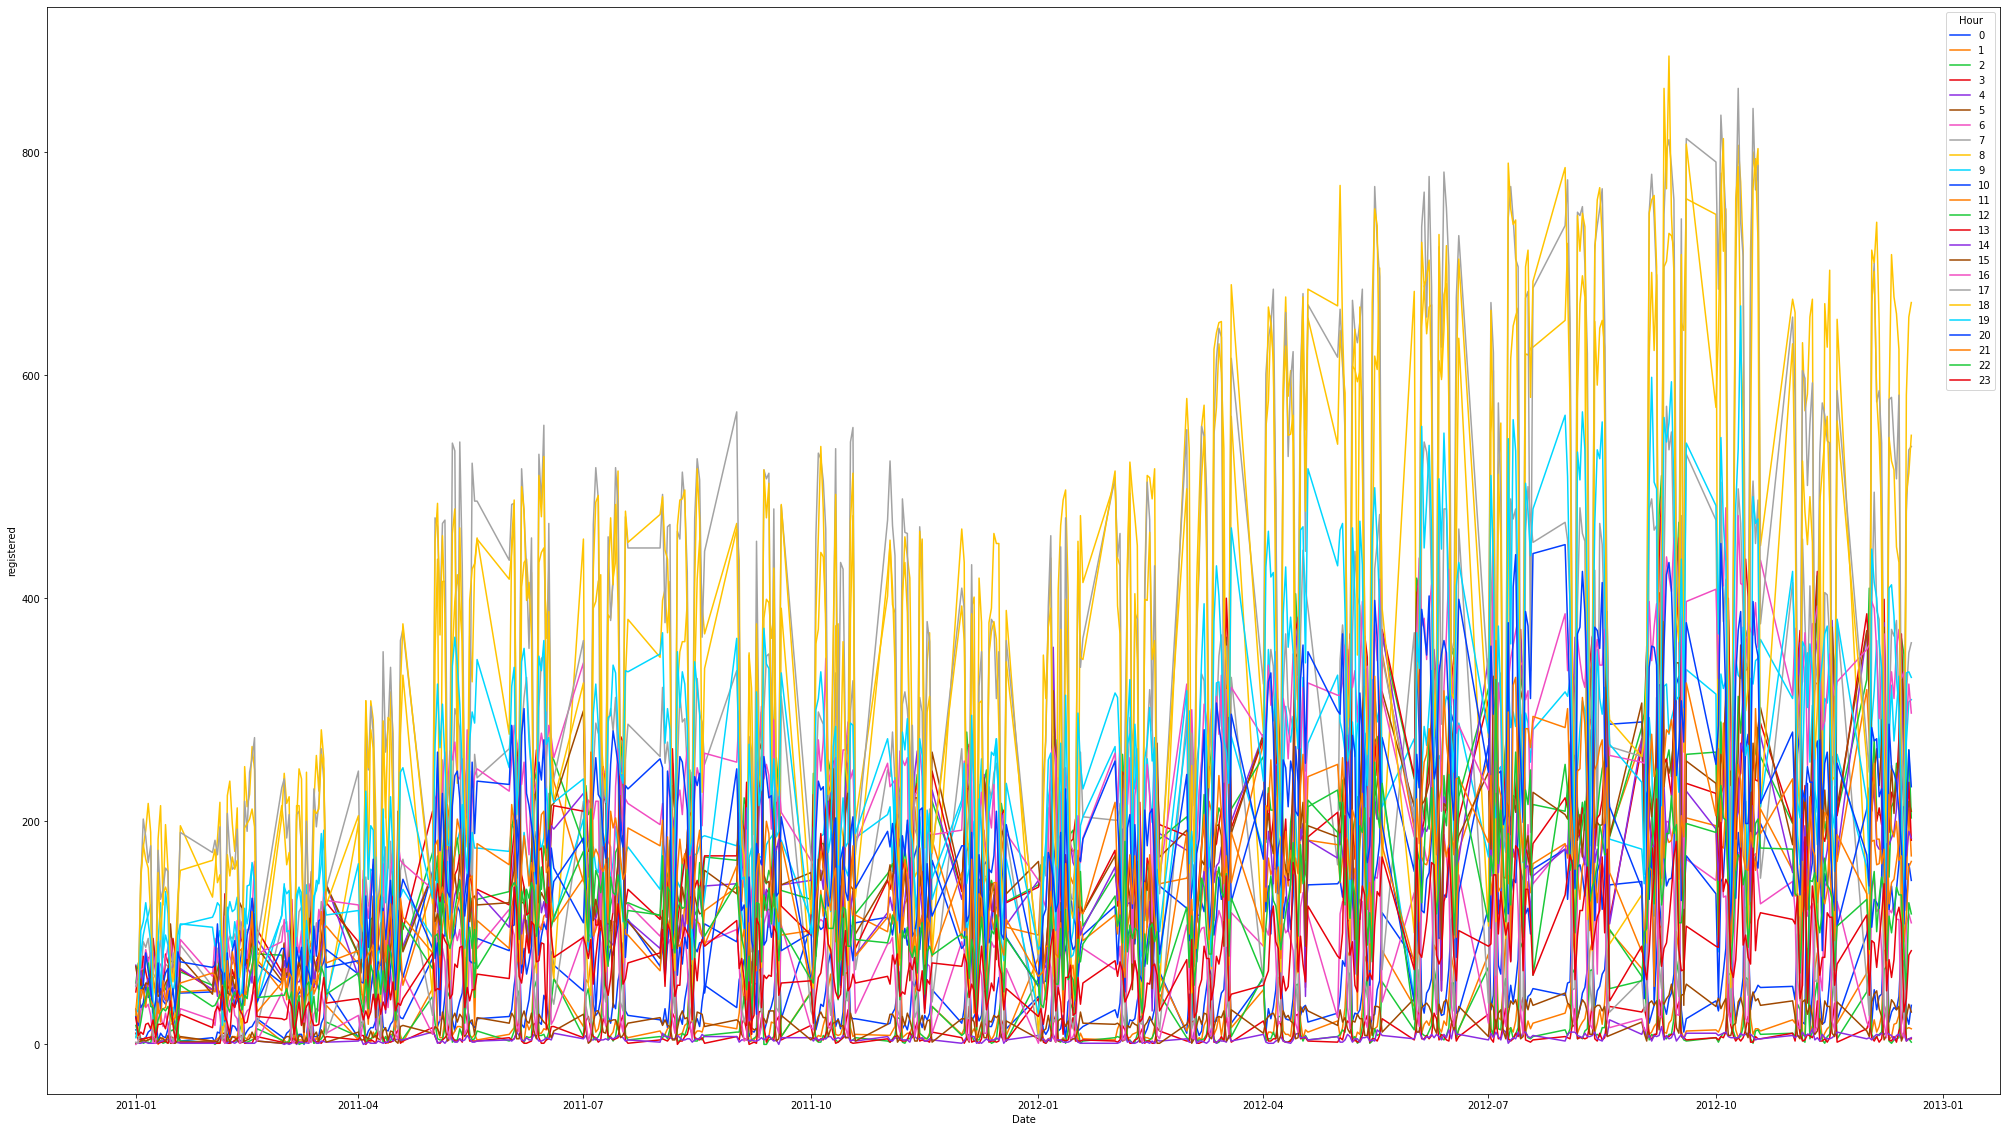

In [16]:
f,axes = plt.subplots(1,1,figsize = (35,20))
sb.lineplot(x ='Date', y = 'registered', data = train, hue = 'Hour',ax = axes,legend = 'full',palette = 'bright')

위 그래프에서 다른 지역 간의 갑작스러운 주기적 변화는 데이터가 누락되었기 때문이다. 이 지역들이 우리가 결과를 예측해야 하는 지역들입니다.

### 1. Season

<AxesSubplot:xlabel='season', ylabel='count'>

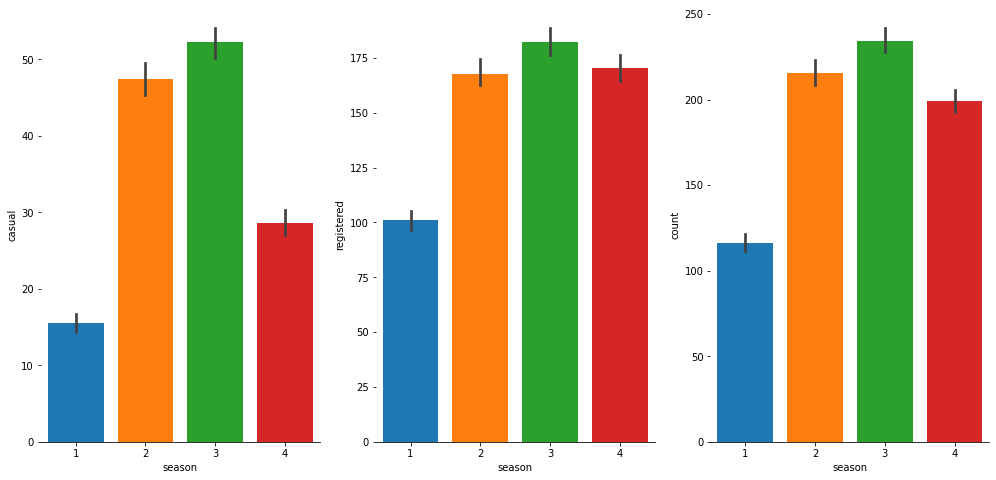

In [20]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'season'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

x축의 1,2,3,4 는 계절을 뜻한다. 1은 sprint, 2는 summer, 3은 fall, 4는 winter 이다. 첫 번째 그래프는 비회원들의 대여 수량을 나타낸 그래프이고 두 번째는 회원들의 대여수량 그리고 마지막 세 번째 그래프는 총 대여 수량을 나타낸다.

겨울에 회원과 비회원의 대여수량이 차이가 나는 것을 볼 수 있다. 날씨가 가장 좋은 봄에서 차이나는게 조금 이상해 보인다. 하지만 여름과 가을은 거의 비슷한 대여 수량을 보인다. 아마 날씨가 좋기 때문에 많은 회원, 비회원을 떠나 자전거를 많이 빌린 듯 하다.

### 2. Holiday

<AxesSubplot:xlabel='holiday', ylabel='count'>

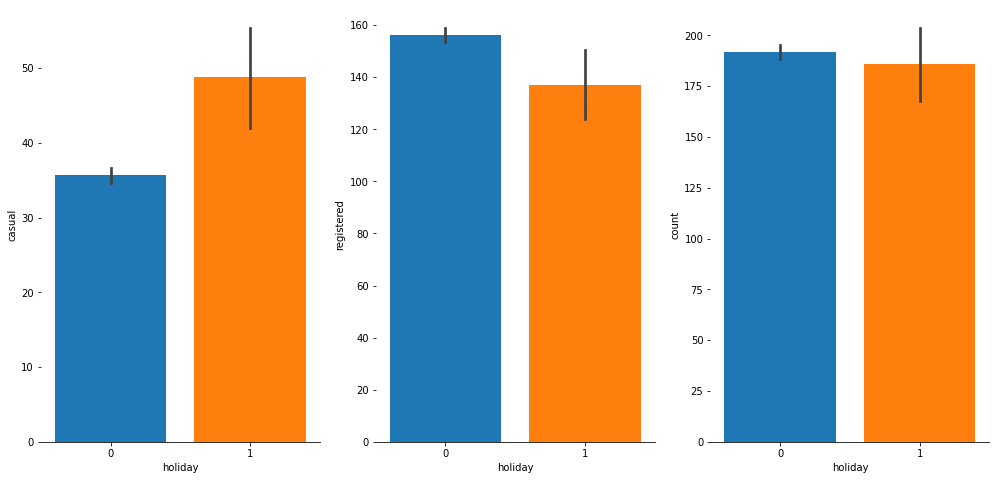

In [21]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'holiday'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

위 그래프는 휴일에 따른 대여량을 나타낸 그래프이다. 회원으로 등록된 사람들이 휴일에는 자전거를 비회원보다 빌리지 않은 것으로 보인다. 총 대여량은 휴일일 때와 아닐때의 차이가 거의 없다.

### 3. Working day

<AxesSubplot:xlabel='workingday', ylabel='count'>

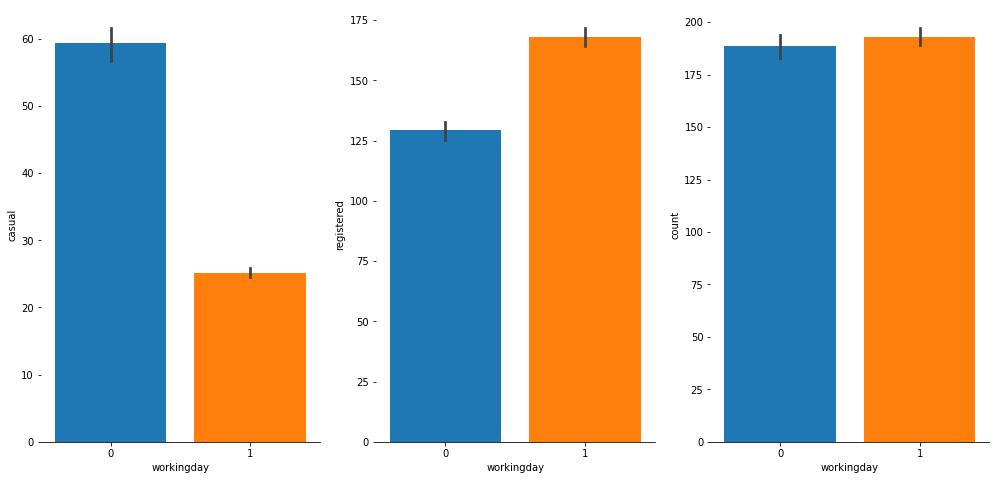

In [24]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'workingday'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

비회원들의 그래프를 합치면 휴일 및 근무일에 영향을 받지 않는 것처럼 보일 수 있지만, 휴일이 비회원의 대여량을 최대 40%까지 증가시키고 근무일에 뒤바뀌는 경향을 볼 수 있다. 따라서 비회원에 대해 두 가지 모델을 각각 다른 모델로 선택하는 것이 좋아 보인다.

따라서 제가 비회원 대여량을 두 개의 모델로 만들고 등록된 모델들을 따로 훈련시킨 다음 그 결과를 합산해 보려고 한다.

### 4. Weather

<AxesSubplot:xlabel='weather', ylabel='count'>

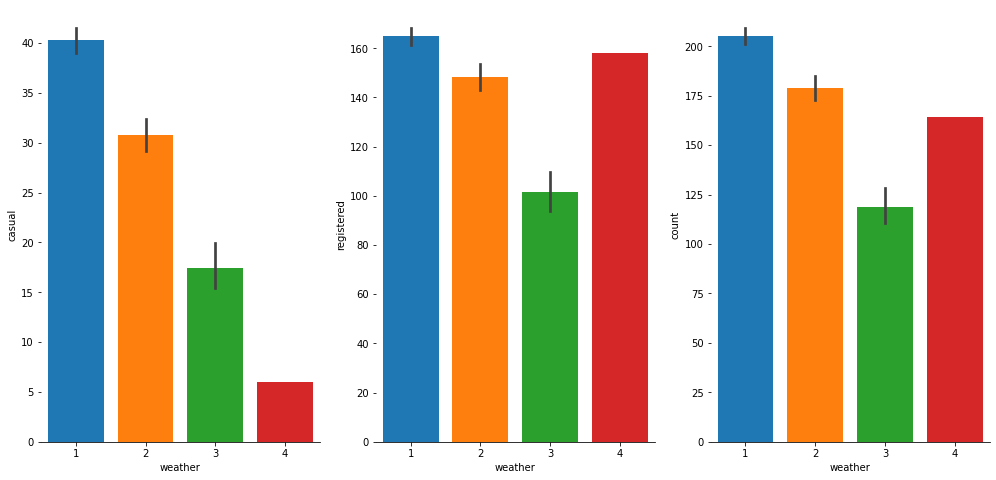

In [25]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'weather'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

날씨에 따른 대여량의 차이를 나타내 본 그래프이다. 1 ~ 4 라는 숫자는 높을 수록 날씨가 가장 안 좋다는 것을 의미한다. 회원 대여량과 총 대여량을 보면 날씨가 가장 안 좋은 날에 오히려 대여량이 많았다. 날씨는 대여량과의 상관관계가 낮음을 볼 수 있다.

### 5. Date & Time

#### 5.1 Hour

<AxesSubplot:xlabel='Hour', ylabel='count'>

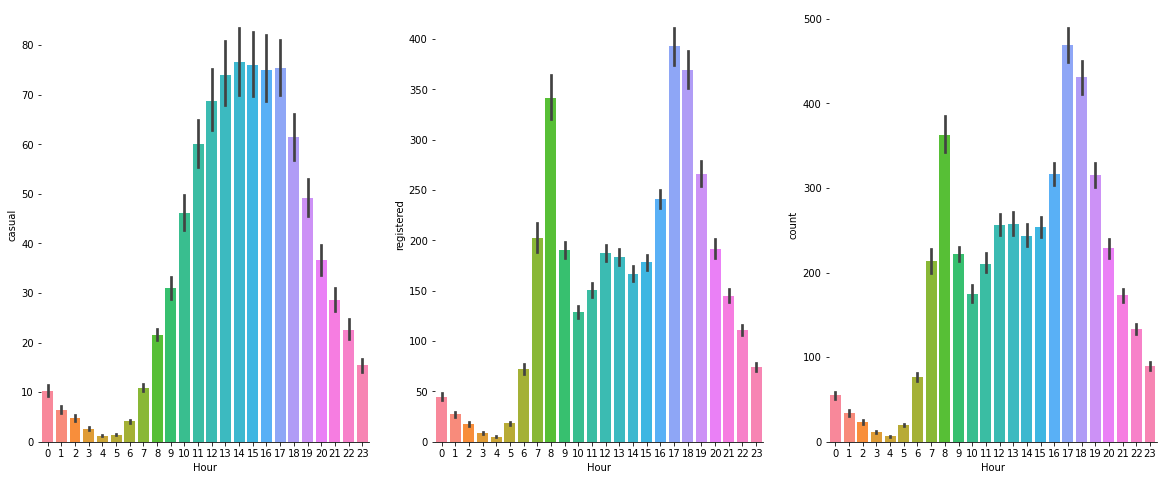

In [28]:
f,axes = plt.subplots(1,3,figsize = (20,8))
sb.despine(left = True)
x = 'Hour'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

위 그래프는 일별 시간대에 따른 대여량의 차이를 나타낸 그래프이다. 전반적으로 예상했든 두 번째, 세 번째 그래프는 출퇴근 시간에 가장 많은 자전거 대여량을 보이고 있다. 이 그래프로 더 확실하게 예측 가능한 일정을 확인할 수 있고 자전거 대여량이 더 늘어날 수 있을 것으로 보인다. 다만 비회원의 경우는 대여하는 경향이 거의 비슷하다.

#### 5.2 Day

<AxesSubplot:xlabel='Day', ylabel='count'>

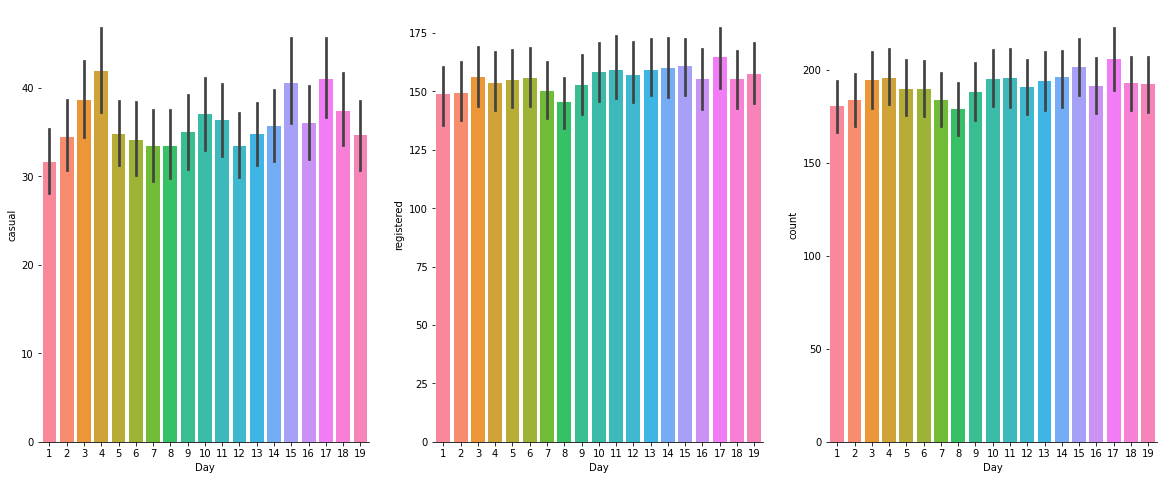

In [29]:
f,axes = plt.subplots(1,3,figsize = (20,8))
sb.despine(left = True)
x = 'Day'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

일별 대여량을 나타낸 그래프이다. 대여량과는 크게 관계가 없어 보인다.

#### 5.3 Month

<AxesSubplot:xlabel='Month', ylabel='count'>

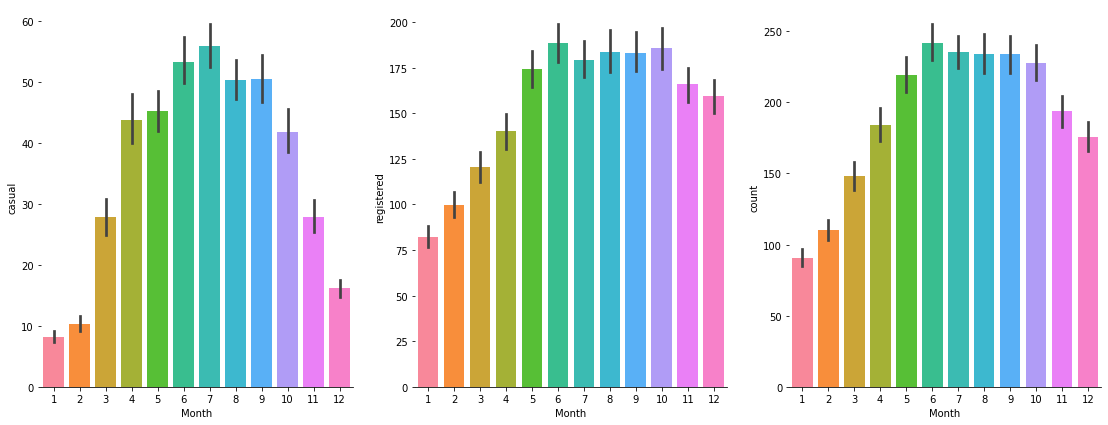

In [30]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Month'

plot = sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

월별 대여량을 보면 모든 피처에서 1,2,3 월에 대여량이 가장 적은것을 확인할 수 있다.
아마 날씨와 연관되어 있는 듯 보인다.

#### 5.4 Year

<AxesSubplot:xlabel='Year', ylabel='count'>

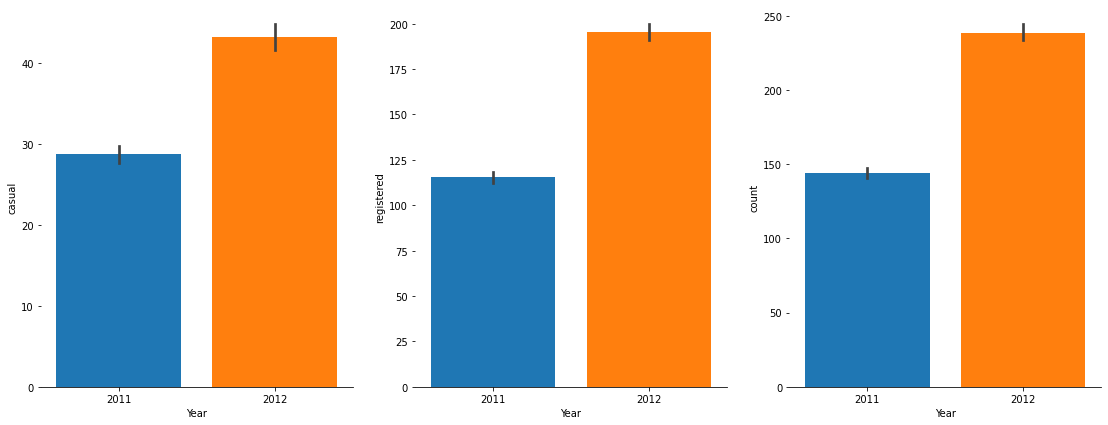

In [31]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Year'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

자료가 좀 오래 되었지만 2011년과 2012년의 대여량을 비교해 보면 2012년의 대여량이 크게 증가한 것을 볼 수 있다.

## 6. 각 범주형 데이터 열에 대한 관련 열 추가

#### 6.1 Season

In [33]:
for i in train.groupby('season').count().index:
    s = 's'+str(i)
    a=[]
    for j in train.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    train[s]=a
train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,Date,Hour,Day,Month,Year,s1,s2,s3,s4
7200,2012-04-18 09:00:00,2,0,1,3,19.68,23.485,44,19.9995,20,...,265,2012-04-18,9,18,4,2012,0,1,0,0
5819,2012-01-17 16:00:00,1,0,1,1,18.86,22.725,63,36.9974,14,...,219,2012-01-17,16,17,1,2012,1,0,0,0
6542,2012-03-09 20:00:00,1,0,1,1,15.58,19.695,32,23.9994,3,...,159,2012-03-09,20,9,3,2012,1,0,0,0
2866,2011-07-08 08:00:00,3,0,1,2,29.52,34.850,74,16.9979,36,...,457,2011-07-08,8,8,7,2011,0,0,1,0
1078,2011-03-09 11:00:00,1,0,1,2,13.12,14.395,76,26.0027,15,...,59,2011-03-09,11,9,3,2011,1,0,0,0


#### 6.2 Weather

In [35]:
for i in train.groupby('weather').count().index:
    s = 'w'+str(i)
    a=[]
    for j in train.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    train[s]=a
train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Month,Year,s1,s2,s3,s4,w1,w2,w3,w4
7749,2012-06-03 06:00:00,2,0,0,1,18.86,22.725,82,7.0015,6,...,6,2012,0,1,0,0,1,0,0,0
9204,2012-09-06 21:00:00,3,0,1,1,26.24,28.790,89,11.0014,32,...,9,2012,0,0,1,0,1,0,0,0
1867,2011-05-04 17:00:00,2,0,1,1,16.40,20.455,71,16.9979,22,...,5,2011,0,1,0,0,1,0,0,0
4501,2011-10-19 15:00:00,4,0,1,3,22.14,25.760,100,8.9981,21,...,10,2011,0,0,0,1,0,0,1,0
5900,2012-02-02 01:00:00,1,0,1,2,18.86,22.725,55,0.0000,3,...,2,2012,1,0,0,0,0,1,0,0


#### 6.3 Hour

In [37]:
for i in train.groupby('Hour').count().index:
    s = 'Hour'+str(i)
    a=[]
    for j in train.Hour:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    train[s]=a
train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23
8064,2012-06-16 09:00:00,2,0,0,1,24.60,30.305,60,6.0032,88,...,0,0,0,0,0,0,0,0,0,0
2837,2011-07-07 03:00:00,3,0,1,1,26.24,28.030,94,7.0015,2,...,0,0,0,0,0,0,0,0,0,0
936,2011-03-03 11:00:00,1,0,1,1,8.20,11.365,29,6.0032,10,...,0,0,0,0,0,0,0,0,0,0
6356,2012-03-02 02:00:00,1,0,1,1,13.94,15.910,53,19.0012,2,...,0,0,0,0,0,0,0,0,0,0
9245,2012-09-08 14:00:00,3,0,0,1,33.62,38.635,52,30.0026,260,...,1,0,0,0,0,0,0,0,0,0


#### 6.4 Month

In [38]:
for i in train.groupby("Month").count().index:
    s = 'Month' + str(i)
    a = []
    for j in train.Month:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    train[s] = a
train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
8972,2012-08-16 05:00:00,3,0,1,1,24.60,28.790,78,11.0014,7,...,0,0,0,0,0,1,0,0,0,0
335,2011-01-15 11:00:00,1,0,0,1,8.20,9.850,55,15.0013,18,...,0,0,0,0,0,0,0,0,0,0
7789,2012-06-04 22:00:00,2,0,1,1,22.96,26.515,52,19.0012,41,...,0,0,0,1,0,0,0,0,0,0
1225,2011-03-15 20:00:00,1,0,1,2,13.94,15.910,71,19.0012,9,...,1,0,0,0,0,0,0,0,0,0
3081,2011-07-17 07:00:00,3,0,0,1,26.24,30.305,73,11.0014,20,...,0,0,0,0,1,0,0,0,0,0


In [40]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 's1', 's2', 's3', 's4', 'w1',
       'w2', 'w3', 'w4', 'Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5',
       'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12',
       'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19',
       'Hour20', 'Hour21', 'Hour22', 'Hour23', 'Month1', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12'],
      dtype='object')

## 7. 불필요한 컬럼들 제거하기

훈련의 필요한 컬럼들만 불러와서 새로운 데이터를 만들자.

In [46]:
train_raw = train[['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5',
       'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12',
       'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19',
       'Hour20', 'Hour21', 'Hour22', 'Hour23','Month1', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12','Year','s1','s2','s3','s4','holiday','workingday',
        'w1','w2','w3','w4','temp','humidity','casual','registered','count']]

In [47]:
train_raw.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,workingday,w1,w2,w3,w4,temp,humidity,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460,36.021955,155.552177,191.574132
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033,49.960477,151.039033,181.144454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000,4.000000,36.000000,42.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000,17.000000,118.000000,145.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000,49.000000,222.000000,284.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000,367.000000,886.000000,977.000000


In [48]:
train_raw.columns

Index(['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7',
       'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12', 'Hour13', 'Hour14',
       'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19', 'Hour20', 'Hour21',
       'Hour22', 'Hour23', 'Month1', 'Month2', 'Month3', 'Month4', 'Month5',
       'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12',
       'Year', 's1', 's2', 's3', 's4', 'holiday', 'workingday', 'w1', 'w2',
       'w3', 'w4', 'temp', 'humidity', 'casual', 'registered', 'count'],
      dtype='object')

## 8. 훈련세트 및 테스트 세트 준비하기

### 8.1 훈련 세트

먼저 훈련 세트에서 필요없는 casual, registered, count 컬럼을 drop하자.

In [49]:
df_train_x = train_raw.drop('casual',axis = 1).drop('registered',axis=1).drop('count',axis=1)
df_train_x.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,s3,s4,holiday,workingday,w1,w2,w3,w4,temp,humidity
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.251056,0.251148,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.433641,0.433694,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000


In [50]:
df_train_y = train_raw['count']
df_train_y.describe

<bound method NDFrame.describe of 0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64>

## 9. 머신러닝 모델로 예측하기

모델 학습에 앞서 필요한 머신러닝 모델을 임포트한다.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
# 경고메세지 제거
import warnings
warnings.filterwarnings(action='ignore')

먼저 훈련 세트와 테스트 세트를 train_test_split 메서드로 나누어 잘 나누어 준다.

In [62]:
x_train, x_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

#### 9.1 선형 회귀

In [64]:
lr = LinearRegression().fit(x_train, y_train)
predictions = lr.predict(x_test)

for i in range(len(predictions)):
    predictions[i] = max(1,i)

print(np.sqrt(mean_squared_log_error( y_test, predictions )))

2.5539889699853435


결과값이 1보다 작지 않다는 것을 알기 때문에 오류를 계산하기 전에 모든 음수 값을 1로 바꿉니다.

In [68]:
lr = LinearRegression().fit(df_train_x, df_train_y)

#### 9.2 로지스틱 회귀

In [63]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

Y_pred = lr.predict(x_test)

lr.score(x_train, y_train)

0.017291689181886956

#### 9.3 Support Vector Machines

In [65]:
svc = SVC()

svc.fit(x_train, y_train)

Y_pred = svc.predict(x_test)

svc.score(x_train, y_train)

0.015346374148924672

#### 9.4 랜덤 포레스트

In [66]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(x_train, y_train)

Y_pred = random_forest.predict(x_test)

random_forest.score(x_train, y_train)

0.9789257538095752

#### 9.5 k-최근접 이웃 

In [74]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(x_train, y_train)

Y_pred = knn.predict(x_test)

knn.score(x_train, y_train)

0.33200043229222953

#### 9.6 xgboost

In [75]:
xgb  = XGBClassifier()
xgb.fit(x_train, y_train)

Y_pred = xgb.predict(x_test)

xgb.score(x_train, y_train)

[00:37:13] WARNING: /tmp/pip-build-gopfpmzp/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9369934075434994